<a href="https://colab.research.google.com/github/restrepo/COVID-19/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 data for Colombia

Use of [public Covid-19 in GitHub](https://github.com/CSSEGISandData/COVID-19) data from: 
[Center for Systems Science and Engineering (CSSE)](https://systems.jhu.edu/):

* Hongru Du, Lauren Gardner, and Ensheng Dong, An interactive web-based dashboard to track COVID-19 in real time, http://www.thelancet.com/infection Published:February 19, 2020, DOI:https://doi.org/10.1016/S1473-3099(20)30120-1

For examples of use of the data see Jupyter Notebook `covid19_analysis.ipynb`: [[local](./covid19_analysis.ipynb)] [[GitHub](https://github.com/restrepo/Covid-19/blob/master/covid_analysis.ipynb)] [[Colab](https://colab.research.google.com/github/restrepo/Covid-19/blob/master/covid_analysis.ipynb)]

[Official Colombia data](https://infogram.com/covid-2019-ins-colombia-1hnq41zg9ord63z)

[El País dashboard](https://elpais.com/sociedad/2020/04/07/actualidad/1586251212_090043.html) Not updated

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re
#See https://strftime.org/
import datetime
import numpy as np
from scipy import optimize as opt

In [3]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def RO(td,γ=1./5.7,μ=1/(70*365)):
    return 1+np.log(2)/(td*(μ+γ))    
    
def date_range(date_start='2/23/20',date_end='3/03/20',date_step=1,
               strptime_format="%m/%d/%y",
               strftime_format="%-m/%-d/%y"):
    dr=[]
    start = datetime.datetime.strptime(date_start,strptime_format )
    end = datetime.datetime.strptime(date_end,strptime_format)
    step = datetime.timedelta(days=date_step)
    while start <= end:
        #avoid leading zeroes: https://stackoverflow.com/a/2073189/2268280
        dr.append(start.strftime(strftime_format))
        start += step
    return dr

def index_field(df,column,filter=None):
    '''
    WARNING: Nonumerical columns are dropped
    
    Parameters:
    ----------
    filter: list, default None
        Select only the columns in this list
    '''
    dff=df.copy()
    if filter:
        dff=df[[column]+list(filter)]
    return dff.groupby(column).sum()

def get_infected(country,date_start=None,date_end=None,DataFrame=None,
      DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/',
      DataFile='master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
      ):
    '''
    Obtenga la lista de infectados de un país
     country: País
     date_start: Fecha inicial en el formato MM/DD/YY, e.g. '3/10/20' o None
     date_end  : Fecha final en el formato MM/DD/YY, e.g. '3/10/20' o None
     si alguna de las fechas esta en None se toma de los extremos del rango
     de fechas disponible
    '''
    if DataFrame is None:
        df=pd.read_csv('{}{}'.format(data_source,data_file))
        df=df.reset_index(drop=True)
    else:
        df=DataFrame.copy()

    d=[ c for c in df.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[0-9]{2}',c)]
    if not date_start:
        date_start=d[0]
    if not date_end:
        date_end=d[-1]
    dr=date_range(date_start=date_start,date_end=date_end)
    #country in df.index
    cvrg=df[dr]
    y=cvrg.loc[country].tolist()              
    return y

def dataframe_doubling(x,y,start_date,final_date,p03=10):
    '''
    x: list of days
    y: list of infected
    '''
    sp=pd.DataFrame()
    if len(x)<3:
        print('WARNING: Not enough data: at least 3 days')
        return sp
    spd={'start_date':start_date,'final_date':final_date}
    for d in x[2:]:
        exp_fit = opt.curve_fit(exponential_model,x[:d],y[:d],p0=[1,0.4,p03])
        if exp_fit[1][1,1] is np.inf:
            print('WARNING: exponential fit faild for p0[3]={}'.format(p03))
        spd['g']=exp_fit[0][1]
        N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
        if exponential_model(t0,N0,g,t0)==N0:
            Td=np.log(2)/g
            spd['N0']=exp_fit[0][0]
            spd['t0']=exp_fit[0][2]
            spd['Td']=Td
            spd['day']=d
            spd['infected']=y[d-1]
        sp=sp.append(spd,ignore_index=True)

    sp['day']=sp['day'].astype(int)
    sp['infected']=sp['infected'].astype(int)
    return sp

## Load data

In [4]:
DataSource='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/'
DataFile='master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
cva=pd.read_csv('{}{}'.format(DataSource,DataFile))
cva=cva.reset_index(drop=True)
#Special cases
c='Hong Kong'
try:
    cva.loc[cva[cva['Province/State']==c].index[0],'Country/Region']=c
except IndexError:
    pass  

In [5]:
FIX_COLUMNS=False
if FIX_COLUMNS:
    cva=cva.rename({'3/21/202':'3/21/20'},axis='columns')

In [6]:
d=[ c for c in cva.columns if re.search(r'^[0-9]{1,2}\/[0-9]{1,2}\/[1920]{2}',c)]
cv=index_field(cva,"Country/Region",filter=d)

## Fix wrong data


In [7]:
FIX_DATA=False
if FIX_DATA:
    ic=cva[cva['Country/Region']=='Colombia'].index[0]
    cva.loc[ic,'3/23/20']=271

last update

In [8]:
dmax=d[-1]
dmax

'4/16/20'

In [9]:
if len(dmax.split('/')[-1])>2:
    print('WARNING: Date format changed!!!!')

## Fit to logistic or exponential model
See: 
* https://twitter.com/burkert_andreas/status/1239692655833071616
    * https://raw.githubusercontent.com/restrepo/Covid-19/master/covid-19.jpeg

* Method for Python explained in 
[Covid-19 infection in Italy. Mathematical models and predictions](https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d):

> While the logistic model describes an infection growth that is going to stop in the future, the exponential model describes an unstoppable infection growth. For example, if a patient infects 2 patients per day, after 1 day we’ll have 2 infections, 4 after 2 days, 8 after 3 and so on. The most generic exponential function is:

$$f(x,a,b,c)=a\operatorname{e}^{b(x-c)}\,.$$

Which can be [interpreted as](https://en.wikipedia.org/wiki/Doubling_time)
$$N(t)=N(t_0)\operatorname{e}^{g(t-t_0)}$$

or

$g = \dfrac{\ln\left(N(t)/N(t_0)\right)}{t-t_0}$

* $N(t)$ = the number of infected at time $t$
* $N(t_0)$ = the number of infected at time $t_0$
* $g$ = growth rate
* $t$ = time (usually in days)

Doubling time $T_d$:

$T_d = \dfrac{\ln(2)}{g}$

$T_d = (t-t_0)\dfrac{\ln(2)}{\ln\left(N(t)/N(t_0)\right)}$

For doubling times analysis for other countries see [Forbes](https://www.forbes.com/sites/startswithabang/2020/03/17/why-exponential-growth-is-so-scary-for-the-covid-19-coronavirus/#66dd44434e9b) - [Result](https://raw.githubusercontent.com/restrepo/Covid-19/master/img/doubling.jpg)



# Colombia

### Select data for Colombia

In [10]:
NOT_OFFICIAL_UPDATE=False
c='Colombia'
max_forecast=1000
prediction=23
extra_days=16
start_day='3/9/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
if NOT_OFFICIAL_UPDATE:
    today=input('Last infected: ')
    y.append(int(today))
x=list(range(1,len(y)+1))

### Logistic model for Colombia

In [11]:
logistic_fit = opt.curve_fit(logistic_model,x,y,p0=[2,10,100])
logistic_end=int(logistic_fit[0][2])
'logistic end: {} ± {} infected'.format(logistic_end,
                               int(np.sqrt(logistic_fit[1][2,2])))

'logistic end: 4159 ± 144 infected'

### Exponential model for Colombia

Prepare data

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
exp_fit = opt.curve_fit(exponential_model,x,y,p0=[1,0.4,30])
try:
    Δb=np.sqrt(exp_fit[1][1,1])
except:
    Δb=0
'exponential `b`-fitted parameter: {}  ± {}'.format(exp_fit[0][1].round(3),Δb.round(3))

'exponential `b`-fitted parameter: 0.088  ± 0.004'

Prediction next day

In [14]:
exp_fit_co=exp_fit[0].copy()
exponential_model_co=lambda x: exponential_model(x, exp_fit_co[0],exp_fit_co[1],exp_fit_co[2]  )
infc=exponential_model_co(x[-1]+1  )
pinfc=exponential_model(x[-1]+1, exp_fit_co[0],exp_fit_co[1]+Δb,exp_fit_co[2]  )-infc
minfc=infc-exponential_model(x[-1]+1, exp_fit_co[0],exp_fit_co[1]-Δb,exp_fit_co[2]  )
next_day=r'next day:  $%g^{+%g}_{-%g}$' %(
                        int( infc ),int( pinfc ),int( minfc )  )
print('day {}:  {} infected'.format(x[-1]+1,next_day) )

day 40:  next day:  $4021^{+780}_{-653}$ infected


Iterpretation in terms of
$$N(t)=N(t_0)\operatorname{e}^{g(t-t_0)}$$

In [15]:
N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
if exponential_model(t0,N0,g,t0)==N0:
    Td=np.log(2)/g
else:
    print('WARNING: N(t) interpretation not working')
    Td=None
if Td:
    dt=re.sub('\.0\s',' ', '(doubling time = {} days)'.format(Td.round(1)
        ))
    texmodel='N(t)=N(t_0)e^{t-t_0}='
    print('T_d →  {}'.format(dt))
else:
    texmodel=''
    dt=''

T_d →  (doubling time = 7.8 days)


Visualization

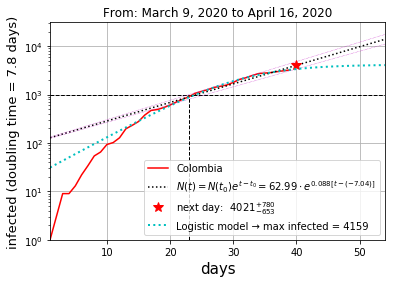

In [16]:
LOGISTIC=True
ERRORS=True
ylinlog='log'
xx=list(range(x[0],x[-1]+extra_days))
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%s%g\cdot e^{%g[t-(%g)]}$' %(texmodel,
                                             exp_fit[0][0].round(2),
                                             exp_fit[0][1].round(3),
                                             exp_fit[0][2].round(2)) )
if ERRORS:
    plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1]+Δb,exp_fit[0][2]),
         'm:',lw=0.5)
    plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1]-Δb,exp_fit[0][2]),
         'm:',lw=0.5)
plt.hlines(max_forecast,xx[0],xx[-1],linestyles='--',lw=1)
plt.vlines(prediction,ymin,max_forecast,linestyles='--',lw=1)

plt.title('From: {} to {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y"),
    datetime.datetime.strptime(dmax,"%m/%d/%y").strftime("%B %-d, %Y") ) )
plt.plot(x[-1]+1,infc,'r*',markersize=10,
         label=next_day
         )

if LOGISTIC:
    plt.plot(xx,
         logistic_model(xx,logistic_fit[0][0],logistic_fit[0][1],logistic_fit[0][2]),
         'c:',lw=2,label='Logistic model → max infected = {}'.format(logistic_end)
          )

plt.legend()#(loc='upper left')
plt.xscale('linear')
plt.yscale(ylinlog)
plt.xlabel('days',size=15)
plt.ylabel('infected '+dt,size=13 )
if ylinlog=='linear':
    xmax=x[-1]+2
    ymax=y[-1]+infc+Δb
else:
    xmax=xx[-1]
    ymax=max_forecast+30000
plt.xlim(xx[0],xmax)
plt.ylim(ymin,ymax)
plt.grid()
plt.savefig('img/Colombia.png')

Phenomenological model:
https://fonte.es/A-CIENCIA/2020-04-04~Matematicas_para_una_epidemia_-_Propagacion_del_SARS-CoV-2.html


## Doubling time

In [17]:
sp=dataframe_doubling(x,y,start_date=start_day,final_date=dmax,p03=15)

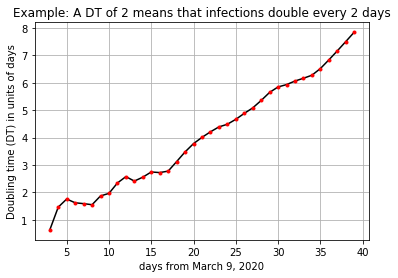

In [18]:
plt.plot(sp['day'],sp['Td'],'k-')
plt.plot(sp['day'],sp['Td'],'r.')
plt.title('Example: A DT of 2 means that infections double every 2 days')
plt.xlabel('days from {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y")
  ))
plt.ylabel('Doubling time (DT) in units of days')
plt.grid()
plt.savefig('doublingtime.png')

RO estimation (See Appendix)

(1, 6)

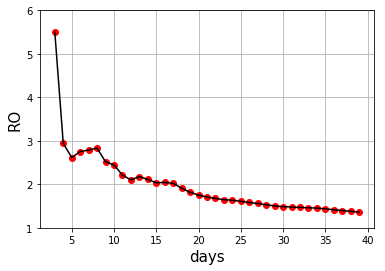

In [19]:
γ=1./4.1 # 1/days #less worst value
μ=1/(70*365) #1/days #Does not matter at all!
plt.plot(sp['day'],RO(sp['Td'].values,γ,μ   ),'ro' )
plt.plot(sp['day'],RO(sp['Td'].values,γ,μ  ),'k-' )
plt.grid()
plt.xlabel('days',size=15)
plt.ylabel('RO',size=15)
plt.ylim(1,6)

3645.624362914032 176.89252975789987 45.25287907519681 
 [[1.70176866e+04 1.34740521e+03 1.20950472e+02]
 [1.34740521e+03 1.31384565e+02 1.06672801e+01]
 [1.20950472e+02 1.06672801e+01 9.14765409e-01]]
max infected: 3645.624362914032
TOTAL: 3233 → NEW: 128


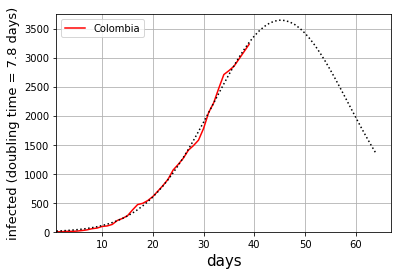

In [20]:
def gaussian_model(xx,A,s,tm):
    xx=np.asarray(xx)
    return A*np.exp(-( (xx-tm)**2   )/(2*s)   ) 

fit=opt.curve_fit(gaussian_model,x,y,p0=[8000,6,20])
A =fit[0][0]
s =fit[0][1]
tm=fit[0][2]
print(A,s,tm,'\n',fit[1])
print('max infected: {}'.format(A))

ylinlog='linear'
extra_days=26
xx=np.array(range(x[0],x[-1]+extra_days))
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         gaussian_model(xx,A,s,tm),
         'k:' )

plt.legend()#(loc='upper left')
plt.xscale('linear')
plt.yscale(ylinlog)
plt.xlabel('days',size=15)
plt.ylabel('infected '+dt,size=13 )
if ylinlog=='linear':
    xmax=x[-1]+2
    ymax=y[-1]+infc+Δb
else:
    xmax=xx[-1]
    ymax=max_forecast+30000
plt.xlim(xx[0],xmax+extra_days)
plt.ylim(ymin,A+100)
plt.grid()
print( 'TOTAL: {} → NEW: {}'.format(y[-1],y[-1]-y[-2]) )

6243.654885894359 110.987723154265 39.72215938141216 
 [[2.92175959e+03 1.67651345e+01 5.60807187e+00]
 [1.67651345e+01 2.34970677e+01 1.23795597e+00]
 [5.60807187e+00 1.23795597e+00 8.75176761e-02]]
max infected: 6243.654885894359
TOTAL: 6315 → NEW: 12 AT PEAK (4/12/20) 


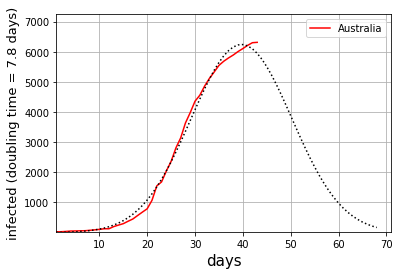

In [21]:
c='Australia'
max_forecast=10000
prediction=34#21
start_day='3/1/20'
y=get_infected(c,date_start=start_day,date_end='4/12/20',DataFrame=cv)
x=list(range(1,len(y)+1))
fit=opt.curve_fit(gaussian_model,x,y,p0=[8000,6,20])
A =fit[0][0]
s =fit[0][1]
tm=fit[0][2]
print(A,s,tm,'\n',fit[1])
print('max infected: {}'.format(A))

ylinlog='linear'
extra_days=26
xx=np.array(range(x[0],x[-1]+extra_days))
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         gaussian_model(xx,A,s,tm),
         'k:' )

plt.legend()#(loc='upper left')
plt.xscale('linear')
plt.yscale(ylinlog)
plt.xlabel('days',size=15)
plt.ylabel('infected '+dt,size=13 )
if ylinlog=='linear':
    xmax=x[-1]+2
    ymax=y[-1]+infc+Δb
else:
    xmax=xx[-1]
    ymax=max_forecast+30000
plt.xlim(xx[0],xmax+extra_days)
plt.ylim(ymin,A+1000)
plt.grid()
print( 'TOTAL: {} → NEW: {} AT PEAK (4/12/20) '.format(y[-1],y[-1]-y[-2]) )

### Other country

In [22]:
c='Australia'
max_forecast=10000
prediction=34#21
start_day='3/1/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=list(range(1,len(y)+1))
exp_fit = opt.curve_fit(exponential_model,x,y,p0=[1,0.4,10])
exp_fit[1][1,1]

inf

(27, 20000)

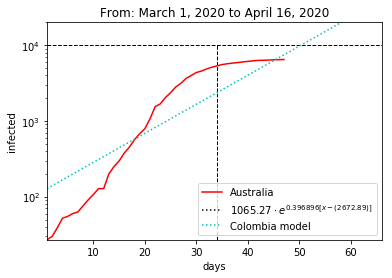

In [23]:
xx=list(range(x[0],x[-1]+20))
if min(y)>0:
    ymin=min(y)
else:
    ymin=1

plt.plot(x,y,'r-',label=c)
plt.plot(xx,
         exponential_model(xx,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]),
         'k:',
         label=r'$%g\cdot e^{%g[x-(%g)]}$' %(exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) )

plt.plot(xx,exponential_model_co(xx),'c:',label='Colombia model')

plt.hlines(max_forecast,xx[0],xx[-1],linestyles='--',lw=1)
plt.vlines(prediction,ymin,max_forecast,linestyles='--',lw=1)

plt.title('From: {} to {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y"),
    datetime.datetime.strptime(dmax,"%m/%d/%y").strftime("%B %-d, %Y") ) ) 
plt.legend(loc='best')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('days')
plt.ylabel('infected')
plt.xlim(xx[0],xx[-1])
plt.ylim(ymin,max_forecast+10000)

In [24]:
N0=exp_fit[0][0];g=exp_fit[0][1];t0=exp_fit[0][2]
if exponential_model(t0,N0,g,t0)==N0:
    Td=np.log(2)/g
else:
    print('WARNING: N(t) interpretation not working')
    Td=None
if Td:
    dt='(doubling time = {} days)'.format(Td.round(2))
    print('T_d →  {}'.format(dt))

T_d →  (doubling time = 1.75 days)


In [25]:
#Australia
stop_date='4/10/20'
y=get_infected(c,date_start=start_day,date_end=stop_date,DataFrame=cv)
x=list( range(1,len(y)+1) )
spa=dataframe_doubling(x,y,start_date=start_day,final_date=stop_date,p03=20)#25

In [26]:
c='Spain'
start_day='3/1/20'
stop_date='4/16/20'
y=get_infected(c,date_start=start_day,date_end=stop_date,DataFrame=cv)
x=list( range(1,len(y)+1) )
sps=dataframe_doubling(x,y,start_date=start_day,final_date=stop_date,p03=20)

In [27]:
c='Italy'
start_day='3/1/20'
stop_date='4/6/20'
y=get_infected(c,date_start=start_day,date_end=stop_date,DataFrame=cv)
x=list( range(1,len(y)+1) )
spi=dataframe_doubling(x,y,start_date=start_day,final_date=stop_date)

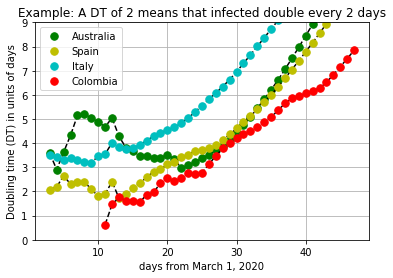

In [28]:
plt.plot(spa['day'],spa['Td'],'k--',label='_nolegend_')
plt.plot(spa['day'],spa['Td'],'g.',markersize=15,label='Australia')
plt.plot(sps['day'],sps['Td'],'k--',label='_nolegend_')
plt.plot(sps['day'],sps['Td'],'y.',markersize=15,label='Spain')
plt.plot(spi['day'],spi['Td'],'k--',label='_nolegend_')
plt.plot(spi['day'],spi['Td'],'c.',markersize=15,label='Italy')
plt.plot(sp['day']+8,sp['Td'],'k--',label='_nolegend_')
plt.plot(sp['day']+8,sp['Td'],'r.',markersize=15,label='Colombia')

plt.title('Example: A DT of 2 means that infected double every 2 days')
plt.xlabel('days from {}'.format(
    datetime.datetime.strptime(start_day,"%m/%d/%y").strftime("%B %-d, %Y")
  ))
plt.ylabel('Doubling time (DT) in units of days')
plt.ylim(0,9)
plt.legend()
plt.grid()
plt.savefig('doublingtime.png')

In [29]:
#Day 1: infected > 10
mininf=10
c='Italy'
start_day='2/19/20'
y=get_infected(c,date_start=start_day,date_end='4/10/20',DataFrame=cv)
x=list( range(1,len(y)+1) )
spi=dataframe_doubling(x,y,start_date=start_day,final_date=dmax,p03=20)
c='Spain'
start_day='2/24/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=list( range(1,len(y)+1) )
sps=dataframe_doubling(x,y,start_date=start_day,final_date=dmax,p03=20)
c='Colombia'
start_day='3/11/20'
y=get_infected(c,date_start=start_day,date_end=dmax,DataFrame=cv)
x=list( range(1,len(y)+1) )
sp=dataframe_doubling(x,y,start_date=start_day,final_date=dmax,p03=20)
c='Korea, South'
start_day='2/18/20'
y=get_infected(c,date_start=start_day,date_end='3/18/20',DataFrame=cv)
x=list( range(1,len(y)+1) )
spk=dataframe_doubling(x,y,start_date=start_day,final_date=dmax)

In [30]:
xstart=3
fd=sp['day'].max()-xstart
fd

34

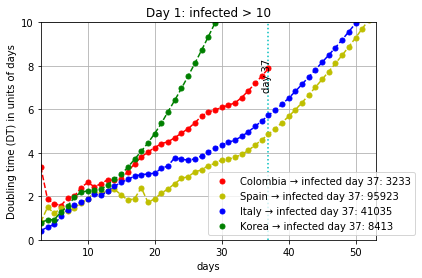

In [31]:
xshift=0
ms=10
plt.close()
plt.plot(sp['day']-xshift,sp['Td'],'r--',label='_nolegend_')
plt.plot(sp['day']-xshift,sp['Td'],'r.',markersize=ms,
         label='Colombia → infected day {}: {}'.format(
                 fd+xstart,sp.loc[fd,'infected']))
plt.plot(sps['day']-xshift,sps['Td'],'y--',label='_nolegend_')
plt.plot(sps['day']-xshift,sps['Td'],'y.',markersize=ms,
         label='Spain → infected day {}: {}'.format(
                 fd+xstart,sps.loc[fd,'infected']))
plt.plot(spi['day']-xshift,spi['Td'],'b--',label='_nolegend_')
plt.plot(spi['day']-xshift,spi['Td'],'b.',markersize=ms,
         label='Italy → infected day {}: {}'.format(
                 fd+xstart,spi.loc[27,'infected']))
plt.plot(spk['day']-xshift,spk['Td'],'g--',label='_nolegend_')
plt.plot(spk['day']-xshift,spk['Td'],'g.',markersize=ms,
         label='Korea → infected day {}: {}'.format(
                 fd+xstart,spk.loc[27,'infected']))

plt.text(sp['day'].values[-1]-xshift-1,8,'day {}'.format(fd+xstart),rotation=90)
plt.vlines(sp['day'].values[-1]-xshift,0,10,linestyles=':',colors='c')
plt.title('Day 1: infected > 10')
plt.xlabel('days')
plt.ylabel('Doubling time (DT) in units of days')
plt.legend(loc=(0.5,0.02))
plt.grid()
plt.xlim(xstart,spi['day'].max()+1)
plt.ylim(0,int(spk['Td'].max()))
plt.savefig('img/contention.png')

### Last update

In [32]:
cv.loc['Colombia'][-1:]

4/16/20    3233
Name: Colombia, dtype: int64

In [33]:
%%javascript
IPython.notebook.save_notebook()    

<IPython.core.display.Javascript object>

In [34]:
import os
if os.getcwd()!='/content':    
    !git commit -am 'automatic update' 2>/dev/null > /dev/null
    !git push origin master 2>/dev/null > /dev/null

## Last official data from Colombia

In [35]:
import requests
import pandas as pd

r=requests.get('https://infogram.com/covid-2019-ins-colombia-1hnq41zg9ord63z')
#https://infogram.com/detallecasos-1h7z2l9yqgdy2ow

head='"data":[[["ID de caso",'
tail=']]]'
js='{}{}{}'.format( head.split(':')[-1],
                 r.text.split(head)[-1].split(tail)[0],
                 tail
             )

df=pd.read_json(js)

for imax in df.columns:
    if len([ l for l in df[imax][0] if l and l!='0' ])==0:
        break

coco=pd.DataFrame([l for l in df[range(1,imax)].values[0]],columns=df[0][0] )
#coco['Fecha']=pd.to_datetime(coco['Fecha de diagnóstico'],format="%d/%m/%Y")

ValueError: Expected object or value

In [ ]:
round(np.sin(0.0001),4)

In [ ]:
try:
    cc=coco[coco['Fecha de diagnóstico']==coco['Fecha de diagnóstico'].values[-1]]
except:
    cc=coco
cc

In [ ]:
coco.shape[0]

In [ ]:
coco.groupby('Atención**').count()[['ID de caso']]

In [ ]:
coco.groupby('Departamento o Distrito').count()[['ID de caso']].sort_values('ID de caso',ascending=False)

## Appedix
Estimation of R0 from the initial phase of an outbreak, https://doi.org/10.1111/j.1365-3156.2009.02413.x
* $R_{0}=1+\dfrac{g}{(\mu+\gamma)}\,,$   [Ref](https://doi.org/10.1016/0035-9203(94)90498-7), $R_{0}\approx1+\dfrac{g}{\gamma}\,,$ if $\mu\ll\gamma$,
* $R_{0}=\left(1+\dfrac{g}{\mu}\right)\left(1+\dfrac{g}{\gamma}\right)$
* $R_{0}=\left(1+\dfrac{g}{\mu}\right)\left(1+\dfrac{g}{\gamma}\right) \mathrm{e}^{\Lambda\left(\tau_{\mathrm{i}}+\tau_{\mathrm{c}}\right)}$

* where
    * $g$ is the exponential growth rate 
    * $\mu$ is the [natural mortality rate](https://worldpopulationreview.com/countries/death-rate-by-country/)
    * $\gamma$ is the inverse of  the [infectious period](https://www.worldometers.info/coronavirus/coronavirus-incubation-period/), 5.7 (95% confidence interval [CI], 4.1 to 7.0) for COVID-19 [Previous ref]
    * $\tau_{\mathrm{e}}$ is extrinsic incubation period
    * $\tau_{\mathrm{i}}$ is the intrinsic incubation period 



Example from https://doi.org/10.1016/0035-9203(94)90498-7, 
Dengue in Sao Paulo
* $\dfrac{1}{\mu}=70\ \text{years}$
* $\dfrac{1}{\gamma}=6\ \text{days}$

In [ ]:
γ=1./4.1 # 1/days #More conservative value
μ=1/(70*365) #1/days #Does not matter at all!
plt.plot(sp['day'],RO(sp['Td'].values,γ=1/5.7  ),'ro' )
plt.plot(sp['day'],RO(sp['Td'].values,γ=1/5.7  ),'k-' )
plt.plot(sp['day'],RO(sp['Td'].values,γ=1/4.1   ),'c:' )
plt.plot(sp['day'],RO(sp['Td'].values,γ=1/13  ),'c:' )
plt.xlabel('days',size=15)
plt.ylabel('RO',size=15)

Normalize with: Sanche S, Lin YT, Xu C, Romero-Severson E, Hengartner N, Ke R. High contagiousness and rapid spread of severe acute respiratory syndrome coronavirus 2. Emerg Infect Dis. 2020 Jul [date cited]. https://doi.org/10.3201/eid2607.200282
* 6–7 days and a basic reproductive number (R0) of 2.2–2.7.
* 2.3–3.3 days. Assuming a serial interval of 6–9 days, we calculated a median R0 value of 5.7 (95% CI 3.8–8.9).

In [ ]:
γ=1./4.1 # 1/days #More conservative value
μ=1/(70*365) #1/days #Does not matter at all!
plt.plot(sp['Td'],RO(sp['Td'].values,γ=1/15 ),'ro' )
plt.plot(sp['Td'],RO(sp['Td'].values,γ=1/15  ),'k-' )
plt.plot(sp['Td'],RO(sp['Td'].values,γ=1/12   ),'c:' )
plt.plot(sp['Td'],RO(sp['Td'].values,γ=1/20  ),'c:' )
plt.xlabel('Td',size=15)
plt.ylabel('RO',size=15)
plt.grid()

$R>R_O$ calculation: Estimating the effective reproduction number of the 2019-nCoV in China
Zhidong Cao, Qingpeng Zhang, Xin Lu, Dirk Pfeiffer, Zhongwei Jia, Hongbing Song, Daniel Dajun Zeng
medRxiv 2020.01.27.20018952; doi: https://doi.org/10.1101/2020.01.27.20018952

$𝑅 = 𝐾^2(𝐿 × 𝐷) + 𝐾(𝐿 + 𝐷) + 1\,,$
where $L$ is the average latent period, $D$ the average latent infectious period, $K$ the logarithmic
growth rate of the case counts as reported by China CDC. We set $𝐿 = 7$ days
and $D=9$ days. 

$k$ is estimated based on at six time points. (Time-1) 12/31/2019, when the  As
such, $𝑡 = 15$,  $𝑌(15) = 27$. (Time-2) 01/04/2020 $𝑡 = 19$ $𝑌(19) = 41$; (c) 01/21/2020, 
$𝑡 = 36$ $𝑌(36) = 375$; (Time-3) 01/22/2020 $𝑡 = 37$ $𝑌(37) = 437$; 
(Time-4) 01/23/2020,  $𝑡 = 38$ $𝑌(38) = 507$; (Time-5) 01/24/2020, $𝑡 = 39$ $𝑌(39) = 572$; 
(Time-6) 01/25/2020,  $𝑡 = 40$ $𝑌(40) = 618$

TODO:
Reproduce the result: $=4.08$

In [ ]:
sp

In [ ]:
import numpy as np
td=6.93 # days
γ=1./6 # 1/days
μ=1/(70*365) #1/days # Very small contribution
1+np.log(2)/(td*(μ+γ))
RO(td,γ,μ)

Example COVID-19

In [ ]:
td=1 # days
RO(td,γ,μ)

In [ ]:
td=2 # days
γ=1./4.1 # 1/days #More conservative value
μ=1/(70*365) #1/days #Does not matter at all!
RO(td,γ,μ)

In [ ]:
td=3.5 # days
RO(td,γ,μ)

In [ ]:
td=6.6 # days
RO(td,γ,μ)

In [ ]:
import IPython